---
title: "Multiclass classification"
author: "Marcin Płodzień"
toc: true
number-sections: true
highlight-style: pygments
jupyter: python3
skip_showdoc: true
skip_exec: true
---

# One-hot encoding

Let's consider problem of data classification when each trainig sample $\vec{x}$ has a label $y$ belonging to one class, where we have $J$ classes in total. Next, we can enumerate each class by index $j \in \{1,\dots, J\}$.

Multiclass classification problems can be considered as task for which each input sample $\vec{x}$ is equiped with the discrete probability distribution 

\begin{equation}
\begin{split}
p = [p_1, p_2, \dots, p_J],\\
\sum_{i=j}^{J} p_j = 1,
\end{split}
\end{equation}
providing information what is the probability that given imput data $\vec{x}$ belongs to given class $j$.

In a particular scenario of a labeled data sample  $\vec{x}$ with label $y$ belonging to class with number $j = 3$ the corresponding probability distribution is

\begin{equation}
 p = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].
\end{equation}

As such, training sample $\vec{x}$ is equiped with a new label $p$.

Such a maping between labels $y$ to discrete probability distribution $p$ in the literature is so-called ${\it one-hot}$ encoding.

One-hot encoding is often used as a way to represent categorical variables in machine learning models. It has the advantage of being able to represent any number of categories, and the labels are mutually exclusive, which can be useful for certain types of models.

# Categorical cross-entropy as a loss function

For multiclass classification task architecture of the Neural Network has output layer with $J$ nodes, corresponding to number of all classes in the training dataset. We interpret output of a neural network $\phi = [\phi_1, \phi_2, \dots, \phi_J]$ as a predicted discrete probability distribution $q = [q_1, q_2, \dots, q_J]$, after applying softmax activation function

\begin{equation}
\phi_j \to q_j = softmax(\phi_j) = \frac{e^{\phi_j}}{\sum_l e^{\phi_j}},
\end{equation}

which assures that $\sum_j q_j = 1$. As such, output $q = \{q_0, q_2, \dots, q_J\}$ can be interpreted as a discrete probability distribution, as well as $p$.

Now, the class prediction is taken as index $l$ corresponding to the maximum value of the class probability, i.e. the model prediction is a index $l$ for which $q_l$ has maximal value - i.e. it provides digit which is most likely a proper label for the input data.

During training the Neural Network we want to minimize distance between input class probability distribution $p$ and predicted class probability distribution $q$. 

To compare two probability distributaion, i.e. to have a measure how $p$ and $p$ differ, we will use earlier introduced Kullback-Leibler divergence:

\begin{equation}
D_{KL}(p || q) = \sum_{l} p_l\log\frac{p_l}{q_l}.
\end{equation}

We can see that

\begin{equation}
D_{KL}(p || q) = \sum_{l}p_l\log{p_l} -\sum_l p_l\log{q_l} \equiv {\cal S} - \text{CE}(p,q),
\end{equation}

where ${\cal S}$ is Shannon entropy for discrete probability distribution $p$, and

\begin{equation}
\text{CE}(p,q) = -\sum_l p_l\log{q_l}
\end{equation}
is called categorical-cross entropy.

Because the Shannon entropy does not depends on the trainable parameters  we can consider only categorical cross-entropy as a loss function.

# Example: Multiclass classification in MNIST dataset

In the context of the MNIST dataset our labels are digits assigned to $28\times28$ pixels images. In such a case, we can consider handwritten digits recognition as a classification problem with $J = 10$ different classes - each for each digit. We assume that each class has assigned arbitrary index $l$ enumerating classes.

In multiclass classification problem, one of the most popular techniqe for for data labels is so called ${\it one-hot encoding}$. One-hot encoding is a way of representing each label as a  $J$-dimensional vectors. Each vector has all elements set to $0$ except one element, whose position corresponds to arbitrary class index $l$.

For example, the digit $3$ has class index $4$ (we count from $0$), thus its label would be represented as 

\begin{equation}
 p = y_{\text{one-hot-encoded}} = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] \\
\end{equation} 

One-hot encoding is often used as a way to represent categorical variables in machine learning models. It has the advantage of being able to represent any number of categories, and the labels are mutually exclusive, which can be useful for certain types of models.

Let' import training data: images and labels

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Nx = 28   # number of pixels in x-direction
Ny = 28   # number of pixels in y-direction
N_class = 10

Now, we define simple feed-forward neural network with one hidden layers with $N_{h_1} = 21$ nodes (as in our previous example) with ReLU activation function):

In [ ]:
# Define the model
N_h_1 = 21
model = nn.Sequential(nn.Linear(Nx*Ny, N_h_1),
                      nn.ReLU(),
                      nn.Linear(N_h_1, N_class)
                     )

Now, we define loss function $L$ as cross-entropy, and Adam as a optimizer for calculating gradient of the loss function $L$ with respect to trainable parameters.

In [ ]:
# Define the loss
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Finally, we will train our model for $N_{\text{epoch}} = 10$ epochs, and collect value of the loss function at each epoch.

In [ ]:
N_epoch = 30

# Training loop
for epoch in range(0, N_epoch):
    running_loss = 0.0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784-dimensional vector
        images = images.view(images.shape[0], -1)
    
        # Clear the gradients
        optimizer.zero_grad()
                
        # One-hot encode the labels
        one_hot_labels = torch.zeros(labels.size(0), 10)
        one_hot_labels[torch.arange(labels.size(0)), labels] = 1
                
        # Forward pass
        output = model(images)
        
        # Calculate the loss
        loss = criterion(output, one_hot_labels)        

        # Backward pass
        loss.backward()  # automatic calculating the loss with respects to trainable parameters
        
        # Update the weights according to chosen optimization function. Here: Adam
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch} - Training loss: {running_loss/len(trainloader)}")

Epoch 0 - Training loss: 0.18809032182036434
Epoch 1 - Training loss: 0.18602984545748436
Epoch 2 - Training loss: 0.18213596730344078
Epoch 3 - Training loss: 0.17800354234763047
Epoch 4 - Training loss: 0.1751984041442336
Epoch 5 - Training loss: 0.1730396168262783
Epoch 6 - Training loss: 0.17177876067965397
Epoch 7 - Training loss: 0.16887598526852726
Epoch 8 - Training loss: 0.16749640748198671
Epoch 9 - Training loss: 0.16485213802686569
Epoch 10 - Training loss: 0.16440106320109513
Epoch 11 - Training loss: 0.16213823579498002
Epoch 12 - Training loss: 0.15957567634593164
Epoch 13 - Training loss: 0.15976456029296937
Epoch 14 - Training loss: 0.15756025875229507
Epoch 15 - Training loss: 0.1583266692863567
Epoch 16 - Training loss: 0.15594374585046825
Epoch 17 - Training loss: 0.1546545083712
Epoch 18 - Training loss: 0.15279026868056134
Epoch 19 - Training loss: 0.1515156587383259
Epoch 20 - Training loss: 0.15149353574842278
Epoch 21 - Training loss: 0.14962262904513746
Epoch 

Now, we can evaluate model on a test dataset and check the confusion matrix:

Text(0.5, 1.0, 'Accuracy = 94.76%')

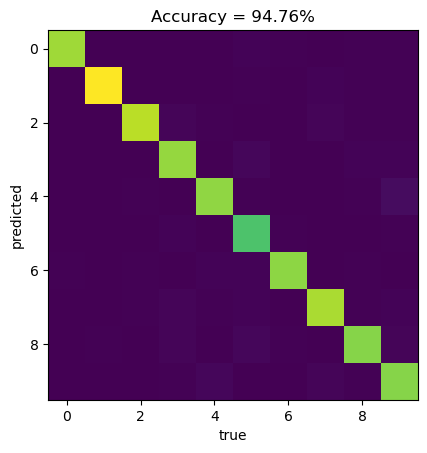

In [ ]:
import numpy as np
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
correct = 0
total = 0
confusion_matrix = np.zeros((10,10))
with torch.no_grad():
    for images, labels in testloader:
        # Flatten MNIST images into a 784-dimensional vector
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        output = model(images)
        
        # Apply the softmax function to the output
        probs = torch.softmax(output, dim=1)
        
        # Get the class with the highest probability
        _, predicted = torch.max(probs, 1)
        
        # Update the correct and total counters
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        for i in range(0, predicted.shape[0]):           
            confusion_matrix[predicted[i].item(),labels[i].item()] += 1

# Calculate the accuracy
accuracy = correct / total

import matplotlib.pyplot as plt
correct = np.sum(np.diagonal(confusion_matrix))
accuracy = correct/np.sum(confusion_matrix)
confusion_matrix = confusion_matrix/np.sum(confusion_matrix)*100
plt.imshow(confusion_matrix)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Accuracy = " + "{:2.2f}".format(accuracy*100) + "%")

As we can see, we reach $\sim 95 \%$ accuracy on test data, which is a huge improvement comparing to our previous neural network with only one output node (accuracy $\sim 59 \%$), where we were using MSE as a loss function.

::: {.callout-tip}
### Exercise
Add two, or three additinal layers to our network. How does it improve accuracy on a test data?
:::